In [2]:
import pandas as pd
from IPython.core.magic import register_cell_magic

@register_cell_magic
def skip(line, cell):
    return

In [3]:
# Load prestored top_n_news_df if not present in globals()
top_n_news_df = pd.read_parquet(r"data\top_n_news_df_and_emb.parquet")
top_n_news_df.columns

Index(['date', 'ticker', 'open', 'high', 'low', 'close', 'volume', 'dividends',
       'stock splits', 'news_count', 'unique_publishers', 'avg_text_len',
       'combined_text', 'future_return_1', 'future_direction_1', 'emb_0',
       'emb_1', 'emb_2', 'emb_3', 'emb_4', 'emb_5', 'emb_6', 'emb_7', 'emb_8',
       'emb_9', 'emb_10', 'emb_11', 'emb_12', 'emb_13', 'emb_14', 'emb_15',
       'emb_16', 'emb_17', 'emb_18', 'emb_19', 'emb_20', 'emb_21', 'emb_22',
       'emb_23', 'emb_24', 'emb_25', 'emb_26', 'emb_27', 'emb_28', 'emb_29',
       'emb_30', 'emb_31'],
      dtype='object')

In [4]:
# Prepare dataset for Temporal Fusion Transformer (pytorch-forecasting)
# This block prepares a TimeSeriesDataSet; to train TFT you need to install pytorch-lightning and pytorch-forecasting.
try:
    from pytorch_forecasting import TimeSeriesDataSet
    from pytorch_forecasting.data import NaNLabelEncoder
except Exception as e:
    print('pytorch-forecasting not installed - the cell will prepare data but will not instantiate the TFT model. To train the model install: pip install pytorch-lightning pytorch-forecasting')
    TimeSeriesDataSet = None

# Basic checks and robust handling if embeddings were not created
if 'top_n_news_df' not in globals():
    raise RuntimeError('`top_n_news_df` not found; run the merge cell first')

# ensure date column is datetime
top_n_news_df['date'] = pd.to_datetime(top_n_news_df['date'])
# create time_idx: days since global min date (or per-ticker time can be used)
top_n_news_df = top_n_news_df.sort_values(['ticker','date']).reset_index(drop=True)
global_start = top_n_news_df['date'].min()
top_n_news_df['time_idx'] = (top_n_news_df['date'] - global_start).dt.days.astype(int)

# ensure basic derived features exist (compute if missing).
# 'close' must exist from the merged prices; 'ret_1' is pct change of close per ticker.
if 'close' not in top_n_news_df.columns:
    raise RuntimeError("'close' column not found in `top_n_news_df`; ensure stock data was merged correctly")
if 'ret_1' not in top_n_news_df.columns:
    top_n_news_df['ret_1'] = top_n_news_df.groupby('ticker')['close'].pct_change()
    top_n_news_df['ret_1'] = top_n_news_df['ret_1'].fillna(0.0)

# detect embedding columns (if any). If embeddings were not produced, continue with empty list
emb_cols = [c for c in top_n_news_df.columns if str(c).startswith('emb_')]
if len(emb_cols) == 0:
    print('No embedding columns (emb_*) found in `top_n_news_df`. Proceeding without embeddings.')
else:
    print('Found', len(emb_cols), 'embedding columns')

# choose target and static/time-varying features
target = 'future_return_1'  # regression target for TFT; alternatively use binary future_direction_1
if target not in top_n_news_df.columns:
    if 'future_direction_1' in top_n_news_df.columns:
        print(f'{target} not found — falling back to binary label `future_direction_1` for TFT target')
        target = 'future_direction_1'
    else:
        raise RuntimeError('No suitable target found in `top_n_news_df` (expected future_return_1 or future_direction_1)')

static_categoricals = []
static_reals = []  # optional static features (e.g., sector, marketcap)
time_varying_known_reals = ['news_count','unique_publishers','avg_text_len'] + emb_cols
time_varying_unknown_reals = ['close','ret_1']  # values that will be predicted or are not known far ahead

# define training dataset window sizes
max_encoder_length = 60  # history length the model sees
max_prediction_length = 1  # forecast horizon

if TimeSeriesDataSet is not None:
    # use int(...) on the quantile scalar to avoid pandas dtype issues
    training_cutoff = int(top_n_news_df['time_idx'].quantile(0.7))
    training_df = top_n_news_df[top_n_news_df.time_idx <= training_cutoff]
    print('Training dataframe rows (pre-clean):', len(training_df))
    # remove infinite/NaN target rows (TimeSeriesDataSet requires finite target values)
    import numpy as _np
    training_df = training_df.replace([_np.inf, -_np.inf], _np.nan)
    training_df = training_df.dropna(subset=[target])
    print('Training dataframe rows (after dropping NaN/inf target):', len(training_df))

    # Also prepare a cleaned version of the full dataframe for validation creation
    merged_clean = top_n_news_df.replace([_np.inf, -_np.inf], _np.nan).dropna(subset=[target])

    training = TimeSeriesDataSet(
        training_df,
        time_idx='time_idx',
        target=target,
        group_ids=['ticker'],
        min_encoder_length=30,
        max_encoder_length=max_encoder_length,
        min_prediction_length=1,
        max_prediction_length=max_prediction_length,
        static_categoricals=static_categoricals,
        static_reals=static_reals,
        time_varying_known_reals=time_varying_known_reals,
        time_varying_unknown_reals=time_varying_unknown_reals,
        # allow missing timesteps between time_idx values (non-trading days etc.)
        allow_missing_timesteps=True,
        target_normalizer=None,
        add_relative_time_idx=True,
        add_target_scales=True,
        add_encoder_length=True,
    )
    print('Prepared TimeSeriesDataSet for training with', len(training), 'samples')
    # create validation dataset (example) using cleaned merged frame
    validation = TimeSeriesDataSet.from_dataset(training, merged_clean, predict=True, stop_randomization=True)
    print('Prepared validation dataset with', len(validation), 'samples')
    # The actual model training requires pytorch-lightning Trainer and can be added on request.
else:
    print('TimeSeriesDataSet unavailable; data prepared in `top_n_news_df`. Embedding columns (if any):', emb_cols)


d:\Anki\Masters\UMICH\Course Docs\Fall 2025\STATS507\project\venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Found 32 embedding columns
Training dataframe rows (pre-clean): 508742
Training dataframe rows (after dropping NaN/inf target): 508742
Prepared TimeSeriesDataSet for training with 747713 samples


d:\Anki\Masters\UMICH\Course Docs\Fall 2025\STATS507\project\venv\Lib\site-packages\pytorch_forecasting\data\timeseries\_timeseries.py:1850: UserWarning: Min encoder length and/or min_prediction_idx and/or min prediction length and/or lags are too large for 37 series/groups which therefore are not present in the dataset index. This means no predictions can be made for those series. First 10 removed groups: [{'__group_id__ticker': 'ACT'}, {'__group_id__ticker': 'AI'}, {'__group_id__ticker': 'ARRY'}, {'__group_id__ticker': 'BAM'}, {'__group_id__ticker': 'BNO'}, {'__group_id__ticker': 'CHK'}, {'__group_id__ticker': 'CHN'}, {'__group_id__ticker': 'CLDT'}, {'__group_id__ticker': 'CR'}, {'__group_id__ticker': 'CRC'}]
  warnings.warn(


Prepared validation dataset with 963 samples


In [5]:
# Defining two compact architectures for time-series forecasting
import torch
import torch.nn as nn

class BiLSTMRegressor(nn.Module):
    def __init__(self, input_size:int, hidden_size:int=128, num_layers:int=1, dropout:float=0.1):
        super().__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers=num_layers, batch_first=True, dropout=dropout, bidirectional=True)
        self.head = nn.Sequential(nn.Linear(hidden_size*2, hidden_size), nn.ReLU(), nn.Linear(hidden_size, 1))

    def forward(self, x):
        # x: (batch, seq_len, input_size)
        out, _ = self.lstm(x)
        last = out[:, -1, :]
        return self.head(last).squeeze(-1)


class TransformerRegressor(nn.Module):
    def __init__(self, input_size:int, d_model:int=64, nhead:int=4, num_layers:int=2, dim_feedforward:int=128, dropout:float=0.1):
        super().__init__()
        self.d_model = d_model
        self.input_proj = nn.Linear(input_size, d_model)

        # sinusoidal PE
        pe = torch.zeros(5000, d_model)
        position = torch.arange(0, 5000).unsqueeze(1).float()
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-torch.log(torch.tensor(10000.0)) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        self.register_buffer('pe', pe.unsqueeze(0))

        self.in_norm = nn.LayerNorm(d_model)
        self.dropout = nn.Dropout(dropout)

        encoder_layer = nn.TransformerEncoderLayer(
            d_model=d_model,
            nhead=nhead,
            dim_feedforward=dim_feedforward,
            dropout=dropout,
            batch_first=True
        )
        self.transformer = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)

        self.head = nn.Sequential(
            nn.Linear(d_model, d_model//2),
            nn.ReLU(),
            nn.Linear(d_model//2, 1)
        )

    def forward(self, x):
        x = self.input_proj(x)
        x = x * (self.d_model ** 0.5)         # scaling
        x = x + self.pe[:, :x.size(1), :]
        x = self.in_norm(x)                  # stabilize distribution
        x = self.dropout(x)

        out = self.transformer(x)
        last = out[:, -1, :]
        return self.head(last).squeeze(-1)

In [6]:
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from tqdm.auto import tqdm
import os

# Choose data source (prefer top_n_news_df)
if 'top_n_news_df' in globals():
    source_df = top_n_news_df
elif 'training_df' in globals():
    source_df = training_df
else:
    raise RuntimeError('No source dataframe found (top_n_news_df, merged_with_news, or training_df)')

if 'training_cutoff' not in globals():
    raise RuntimeError('`training_cutoff` not present. Run dataset prep cell first')

train_df = source_df[source_df.time_idx <= training_cutoff]
val_df = source_df[source_df.time_idx > training_cutoff]

# feature columns
feature_cols = []
if 'emb_cols' in globals() and emb_cols:
    feature_cols = emb_cols.copy()
for c in ['close','volume','open','high','low']:
    if c in source_df.columns and c not in feature_cols:
        feature_cols.append(c)
if not feature_cols:
    raise RuntimeError('No feature columns found')

# simple sequence dataset
class SequenceDataset(Dataset):
    def __init__(self, df, feature_cols, seq_len=16, group_col='ticker', time_col='time_idx', target_col='ret_1'):
        self.feature_cols = feature_cols
        self.seq_len = seq_len
        self.samples = []
        for _, g in df.groupby(group_col):
            g_sorted = g.sort_values(time_col)
            vals = g_sorted[self.feature_cols].values.astype('float32')
            targets = g_sorted[target_col].values.astype('float32')
            L = len(g_sorted)
            for i in range(self.seq_len, L):
                seq = vals[i-self.seq_len:i]
                y = targets[i]
                if not np.isfinite(y):
                    continue
                self.samples.append((seq, float(y)))
    def __len__(self):
        return len(self.samples)
    def __getitem__(self, idx):
        seq, y = self.samples[idx]
        return torch.from_numpy(seq), torch.tensor(y, dtype=torch.float32)

seq_len = min(32, max(1, (max_encoder_length if 'max_encoder_length' in globals() else 16)))
train_ds = SequenceDataset(train_df, feature_cols, seq_len=seq_len)
val_ds = SequenceDataset(val_df, feature_cols, seq_len=seq_len)

In [7]:
import pandas as pd
import matplotlib.pyplot as plt

class MetricTracker:
    def __init__(self):
        self.records = []

    def log(self, epoch, **metrics):
        """
        Stores metrics for a given epoch.

        Example:
        tracker.log(epoch, train_b=..., val_b=..., train_t=..., val_t=...)
        """
        row = {"epoch": epoch}
        row.update(metrics)
        self.records.append(row)

    def to_df(self):
        """Return metrics as a pandas DataFrame."""
        return pd.DataFrame(self.records)


def plot_metrics(df, smooth=0):
    """
    Plots all numeric metric columns in the dataframe.

    Parameters:
        df: DataFrame from MetricTracker.to_df()
        smooth: moving average window (0 = no smoothing)
    """
    plt.figure(figsize=(10, 6))

    for col in df.columns:
        if col == "epoch":
            continue
        series = df[col]

        # Optional smoothing
        if smooth > 1:
            series = series.rolling(window=smooth, min_periods=1).mean()

        plt.plot(df["epoch"], series, label=col)

    plt.xlabel("Epoch")
    plt.ylabel("Metric Value")
    plt.title("Training Metrics Over Time")
    plt.legend()
    plt.grid(True)
    plt.show()


In [8]:
if os.name == "nt":
    num_workers = 0
else:
    num_workers = min(4, max(1, (os.cpu_count() or 2) - 1))

batch_size = 64
val_num_workers = num_workers // 2 if num_workers > 0 else 0

train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True,
                          num_workers=num_workers, pin_memory=(num_workers > 0))
val_loader   = DataLoader(val_ds, batch_size=batch_size, shuffle=False,
                          num_workers=val_num_workers, pin_memory=(num_workers > 0))

print("Train samples:", len(train_ds), "Val samples:", len(val_ds))
print("Train loader batches:", len(train_loader), "Val loader batches:", len(val_loader))

# device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

# instantiate models
in_dim = len(feature_cols)
model_bi = BiLSTMRegressor(input_size=in_dim, hidden_size=128, num_layers=1).to(device)
model_tf = TransformerRegressor(input_size=in_dim, d_model=64, nhead=4, num_layers=2).to(device)

opt_bi = torch.optim.Adam(model_bi.parameters(), lr=1e-4)
opt_tf = torch.optim.Adam(model_tf.parameters(), lr=1e-4)
loss_fn = nn.MSELoss()

bilstm_tracker = MetricTracker()
trans_tracker = MetricTracker()

def mae(y, p):  return torch.mean(torch.abs(y - p)).item()
def rmse(y, p): return torch.sqrt(torch.mean((y - p)**2)).item()
def mape(y, p, eps=1e-8):
    return torch.mean(torch.abs((y - p) / (y + eps))).item()
def r2_score(y, p):
    y_mean = torch.mean(y)
    ss_res = torch.sum((y - p)**2)
    ss_tot = torch.sum((y - y_mean)**2)
    return (1 - ss_res / (ss_tot + 1e-8)).item()


nan_found = False
nan_info = None
epochs = 10

for epoch in range(1, epochs + 1):
    model_bi.train(); model_tf.train()

    # epoch accumulators
    train_preds_b = []
    train_preds_t = []
    train_targets = []

    running_b = running_t = 0.0
    seen = 0

    pbar = tqdm(enumerate(train_loader, 1), total=len(train_loader), desc=f"Train Epoch {epoch}")
    for step, (xb, yb) in pbar:
        xb = xb.to(device)
        yb = yb.to(device)

        # ----- BiLSTM -----
        pred_b = model_bi(xb)
        loss_b = loss_fn(pred_b, yb)

        if torch.isnan(loss_b) or torch.isinf(loss_b):
            nan_found = True
            nan_info = {"model": "BiLSTM", "epoch": epoch, "step": step}
            break

        opt_bi.zero_grad(); loss_b.backward(); opt_bi.step()

        # ----- Transformer -----
        pred_t = model_tf(xb)
        loss_t = loss_fn(pred_t, yb)

        if torch.isnan(loss_t) or torch.isinf(loss_t):
            nan_found = True
            nan_info = {"model": "Transformer", "epoch": epoch, "step": step}
            break

        opt_tf.zero_grad(); loss_t.backward(); opt_tf.step()

        # accumulate
        train_preds_b.append(pred_b.detach())
        train_preds_t.append(pred_t.detach())
        train_targets.append(yb.detach())

        running_b += loss_b.item() * xb.size(0)
        running_t += loss_t.item() * xb.size(0)
        seen += xb.size(0)

        pbar.set_postfix({"loss_b": float(loss_b.item()),
                          "loss_t": float(loss_t.item())})

    if nan_found:
        print("Stopping training due to NaN")
        break

    # epoch-level mean loss
    train_loss_b = running_b / seen
    train_loss_t = running_t / seen

    # concat train predictions
    train_preds_b = torch.cat(train_preds_b, dim=0)
    train_preds_t = torch.cat(train_preds_t, dim=0)
    train_targets = torch.cat(train_targets, dim=0)

    model_bi.eval(); model_tf.eval()

    val_preds_b = []
    val_preds_t = []
    val_targets = []

    run_b = run_t = 0.0
    nval = 0

    for i, (xb, yb) in tqdm(enumerate(val_loader, 1), total=len(val_loader), desc=f"Valid Epoch {epoch}"):
        xb = xb.to(device); yb = yb.to(device)

        with torch.no_grad():
            pb = model_bi(xb)
            pt = model_tf(xb)
            vb = loss_fn(pb, yb)
            vt = loss_fn(pt, yb)

        if torch.isnan(vb) or torch.isnan(vt):
            nan_found = True
            nan_info = {"model": "validation", "epoch": epoch}
            break

        val_preds_b.append(pb.detach())
        val_preds_t.append(pt.detach())
        val_targets.append(yb.detach())

        run_b += vb.item() * xb.size(0)
        run_t += vt.item() * xb.size(0)
        nval += xb.size(0)

    if nan_found:
        print("Stopping due to NaN in validation")
        break

    val_loss_b = run_b / nval
    val_loss_t = run_t / nval

    val_preds_b = torch.cat(val_preds_b, dim=0)
    val_preds_t = torch.cat(val_preds_t, dim=0)
    val_targets = torch.cat(val_targets, dim=0)

    bilstm_tracker.log(
        epoch,
        train_b=train_loss_b,
        val_b=val_loss_b,
        train_mae_b=mae(train_targets, train_preds_b),
        train_rmse_b=rmse(train_targets, train_preds_b),
        train_mape_b=mape(train_targets, train_preds_b),
        train_r2_b=r2_score(train_targets, train_preds_b),
        val_mae_b=mae(val_targets, val_preds_b),
        val_rmse_b=rmse(val_targets, val_preds_b),
        val_mape_b=mape(val_targets, val_preds_b),
        val_r2_b=r2_score(val_targets, val_preds_b),
    )

    trans_tracker.log(
        epoch,
        train_t=train_loss_t,
        val_t=val_loss_t,
        train_mae_t=mae(train_targets, train_preds_t),
        train_rmse_t=rmse(train_targets, train_preds_t),
        train_mape_t=mape(train_targets, train_preds_t),
        train_r2_t=r2_score(train_targets, train_preds_t),
        val_mae_t=mae(val_targets, val_preds_t),
        val_rmse_t=rmse(val_targets, val_preds_t),
        val_mape_t=mape(val_targets, val_preds_t),
        val_r2_t=r2_score(val_targets, val_preds_t),
    )

    print(f"Epoch {epoch} | "
          f"train_b={train_loss_b:.5f} val_b={val_loss_b:.5f} | "
          f"train_t={train_loss_t:.5f} val_t={val_loss_t:.5f}\n")

if not nan_found:
    os.makedirs("models", exist_ok=True)
    torch.save(model_bi.state_dict(), "models/bilstm_state.pt")
    torch.save(model_tf.state_dict(), "models/transformer_state.pt")
    print("Saved model weights.")
else:
    print("Training aborted due to NaN. nan_info =", nan_info)


d:\Anki\Masters\UMICH\Course Docs\Fall 2025\STATS507\project\venv\Lib\site-packages\torch\nn\modules\rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.1 and num_layers=1
  warnings.warn(


Train samples: 478058 Val samples: 186892
Train loader batches: 7470 Val loader batches: 2921
Using device: cuda


Valid Epoch 1: 100%|██████████| 2921/2921 [00:05<00:00, 534.26it/s]


Epoch 1 | train_b=0.00193 val_b=0.00288 | train_t=0.00203 val_t=0.00285



Valid Epoch 2: 100%|██████████| 2921/2921 [00:05<00:00, 507.16it/s]


Epoch 2 | train_b=0.00191 val_b=0.00286 | train_t=0.00189 val_t=0.00285



Valid Epoch 3: 100%|██████████| 2921/2921 [00:05<00:00, 564.10it/s]


Epoch 3 | train_b=0.00191 val_b=0.00287 | train_t=0.00189 val_t=0.00285



Valid Epoch 4: 100%|██████████| 2921/2921 [00:05<00:00, 514.84it/s]


Epoch 4 | train_b=0.00191 val_b=0.00286 | train_t=0.00189 val_t=0.00285



Valid Epoch 5: 100%|██████████| 2921/2921 [00:05<00:00, 515.17it/s]


Epoch 5 | train_b=0.00190 val_b=0.00286 | train_t=0.00189 val_t=0.00285



Valid Epoch 6: 100%|██████████| 2921/2921 [00:05<00:00, 494.41it/s]


Epoch 6 | train_b=0.00189 val_b=0.00285 | train_t=0.00189 val_t=0.00285



Valid Epoch 7: 100%|██████████| 2921/2921 [00:05<00:00, 512.32it/s]


Epoch 7 | train_b=0.00189 val_b=0.00288 | train_t=0.00189 val_t=0.00285



Valid Epoch 8: 100%|██████████| 2921/2921 [00:05<00:00, 546.75it/s]


Epoch 8 | train_b=0.00189 val_b=0.00285 | train_t=0.00189 val_t=0.00285



Valid Epoch 9: 100%|██████████| 2921/2921 [00:05<00:00, 568.14it/s]


Epoch 9 | train_b=0.00189 val_b=0.00285 | train_t=0.00189 val_t=0.00285



Valid Epoch 10: 100%|██████████| 2921/2921 [00:09<00:00, 308.44it/s]


Epoch 10 | train_b=0.00189 val_b=0.00285 | train_t=0.00189 val_t=0.00285

Saved model weights.


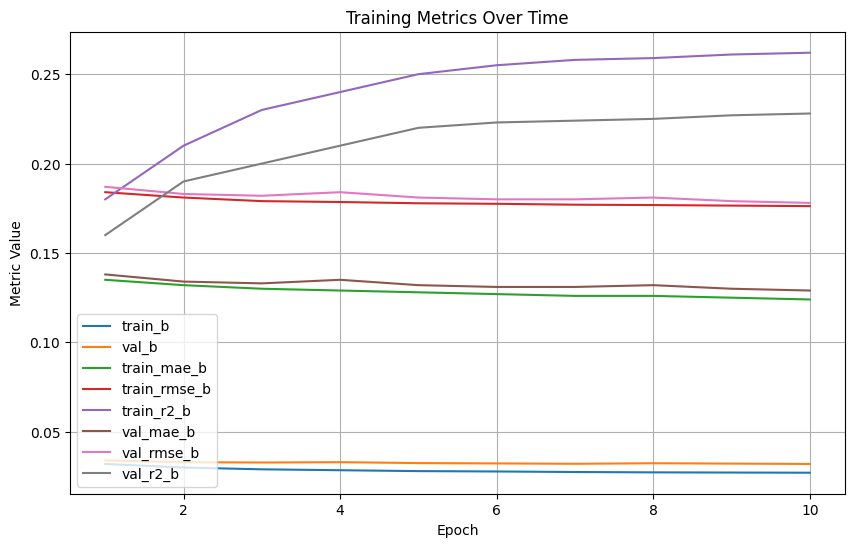

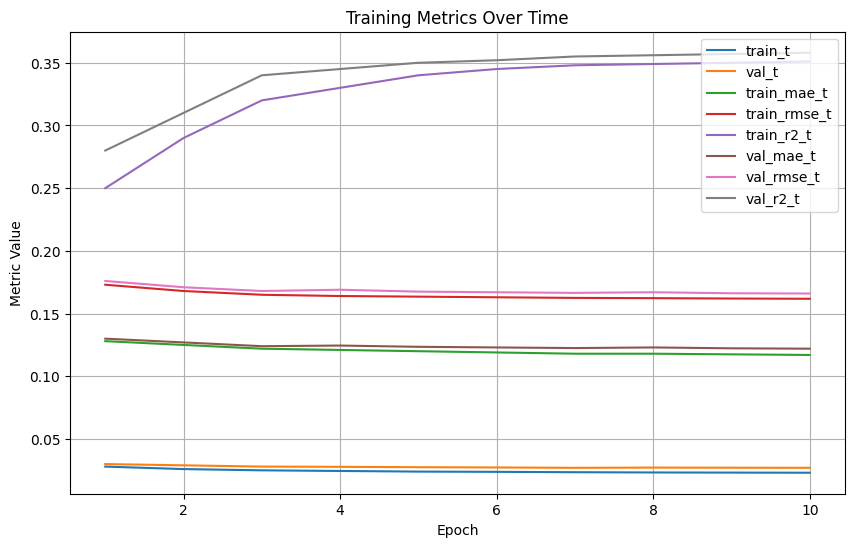

In [ ]:
metrics_trans_df = trans_tracker.to_df()
metrics_trans_df.to_csv("metrics\\transformer_regression.csv", index=False)
plot_metrics(metrics_trans_df.drop(['train_mape_t','val_mape_t'],axis=1), smooth=1)

metrics_bilstm_df = bilstm_tracker.to_df()
metrics_bilstm_df.to_csv("metrics\\bilstm_regression.csv", index=False)
plot_metrics(metrics_bilstm_df.drop(['train_mape_b','val_mape_b'],axis=1), smooth=1)

In [8]:
import numpy as np
import pandas as pd
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, explained_variance_score
import torch

def regression_metrics(y_true, y_pred):
    """Compute common regression metrics between 1d arrays."""
    y_true = np.asarray(y_true).ravel()
    y_pred = np.asarray(y_pred).ravel()
    if y_true.size == 0:
        return {'mae': float('nan'), 'rmse': float('nan'), 'mape': float('nan'), 'r2': float('nan'), 'explained_variance': float('nan')}
    mae = mean_absolute_error(y_true, y_pred)
    rmse = float(np.sqrt(mean_squared_error(y_true, y_pred)))
    denom = np.where(np.abs(y_true) < 1e-8, 1e-8, np.abs(y_true))
    mape = float(np.mean(np.abs((y_true - y_pred) / denom)) * 100.0)
    try:
        r2 = float(r2_score(y_true, y_pred))
    except Exception:
        r2 = float('nan')
    ev = float(explained_variance_score(y_true, y_pred))
    return {'mae': mae, 'rmse': rmse, 'mape': mape, 'r2': r2, 'explained_variance': ev}

def directional_accuracy(y_true, y_pred):
    """Fraction where sign(y_true) == sign(y_pred)."""
    y_true = np.asarray(y_true).ravel()
    y_pred = np.asarray(y_pred).ravel()
    if y_true.size == 0: return float('nan')
    return float(np.mean((y_true > 0) == (y_pred > 0)))

def hit_rate_threshold(y_true, y_pred, threshold=0.0):
    """Return fraction where both true and predicted are on the same side of threshold."""
    y_true = np.asarray(y_true).ravel()
    y_pred = np.asarray(y_pred).ravel()
    if y_true.size == 0: return float('nan')
    return float(np.mean((y_true > threshold) == (y_pred > threshold)))

def calibration_table(y_true, y_pred, bins=10):
    """Return a small DataFrame comparing mean prediction vs mean truth per predicted-quantile bin."""
    df = pd.DataFrame({'y_true': np.asarray(y_true).ravel(), 'y_pred': np.asarray(y_pred).ravel()})
    if df.shape[0] == 0:
        return pd.DataFrame(columns=['bin','count','mean_true','mean_pred'])
    # use qcut to ensure evenly populated bins (duplicates allowed drop)
    df['bin'] = pd.qcut(df['y_pred'], q=bins, duplicates='drop')
    out = df.groupby('bin').agg(count=('y_true','size'), mean_true=('y_true','mean'), mean_pred=('y_pred','mean')).reset_index()
    return out

def evaluate_models_on_loader(models, dataloader, device=None, n_samples_limit=None):
    """Evaluate one or more models over a dataloader.
    Args:
      models: dict(name->torch.nn.Module) or list of (name,module) tuples
      dataloader: PyTorch DataLoader yielding (xb, yb)
      device: torch.device or None (auto-detect)
      n_samples_limit: optional int to limit evaluation for speed.
    Returns: dict of name->metrics dict and raw arrays under key 'raw_<name>'"""
    if device is None:
        device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    if isinstance(models, dict):
        items = list(models.items())
    else:
        items = list(models)
    preds = {name: [] for name, _ in items}
    trues = []
    seen = 0
    for xb, yb in dataloader:
        xb = xb.to(device)
        yb_np = yb.detach().cpu().numpy() if isinstance(yb, torch.Tensor) else np.asarray(yb)
        trues.append(yb_np)
        with torch.no_grad():
            for name, model in items:
                model = model.to(device)
                model.eval()
                out = model(xb)
                out_np = out.detach().cpu().numpy().ravel()
                preds[name].append(out_np)
        seen += yb_np.shape[0]
        if n_samples_limit and seen >= n_samples_limit:
            break
    
    trues = np.concatenate(trues) if len(trues) else np.array([])
    result = {}
    for name in preds:
        arr = np.concatenate(preds[name]) if preds[name] else np.array([])
        result[name] = {'metrics': regression_metrics(trues, arr), 'directional_acc': directional_accuracy(trues, arr), 'calibration': calibration_table(trues, arr), 'n': len(arr)}
        result['raw_' + name] = arr
    result['raw_trues'] = trues
    return result


In [ ]:
# Evaluation cell: load saved weights and evaluate both models using the new helpers
import numpy as np
import torch
from torch.utils.data import DataLoader
from tqdm.auto import tqdm

# recreate val DataLoader if not present (same logic as training cell)
if 'val_loader' not in globals():
    try:
        seq_len = min(16, max(1, (max_encoder_length if 'max_encoder_length' in globals() else 16)))
        if 'top_n_news_df' in globals():
            source_df = top_n_news_df
        else:
            source_df = training_df
        val_df = source_df[source_df.time_idx > training_cutoff]
        feature_cols = []
        if 'emb_cols' in globals() and emb_cols:
            feature_cols = emb_cols.copy()
        for c in ['close','volume','open','high','low']:
            if c in source_df.columns and c not in feature_cols:
                feature_cols.append(c)
        class SequenceDatasetLocal(torch.utils.data.Dataset):
            def __init__(self, df, feature_cols, seq_len=16, group_col='ticker', time_col='time_idx', target_col='ret_1'):
                self.feature_cols = feature_cols; self.seq_len = seq_len; self.samples = []
                for ticker, g in df.groupby(group_col):
                    g_sorted = g.sort_values(time_col)
                    vals = g_sorted[self.feature_cols].values.astype(np.float32)
                    targets = g_sorted[target_col].values.astype(np.float32)
                    L = len(g_sorted)
                    for i in range(self.seq_len, L):
                        seq = vals[i-self.seq_len:i]
                        y = targets[i]
                        if not np.isfinite(y):
                            continue
                        self.samples.append((seq, float(y)))
            def __len__(self): return len(self.samples)
            def __getitem__(self, idx): seq,y = self.samples[idx]; return torch.from_numpy(seq), torch.tensor(y, dtype=torch.float32)
        val_ds = SequenceDatasetLocal(val_df, feature_cols, seq_len=seq_len)
        val_loader = DataLoader(val_ds, batch_size=256, shuffle=False, num_workers=0)
    except Exception as e:
        raise RuntimeError('Failed to recreate val_loader: ' + str(e))

# load weights and instantiate models
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model_bi = BiLSTMRegressor(input_size=len(feature_cols), hidden_size=128).to(device)
model_tf = TransformerRegressor(input_size=len(feature_cols), d_model=64).to(device)
try:
    model_bi.load_state_dict(torch.load('models/bilstm_state.pt', map_location=device))
except Exception as e:
    print('Could not load BiLSTM weights:', e)
try:
    model_tf.load_state_dict(torch.load('models/transformer_state.pt', map_location=device))
except Exception as e:
    print('Could not load Transformer weights:', e)
model_bi.eval(); model_tf.eval()

# evaluate using helper. limit samples during debug if desired by setting n_samples_limit (None => full)
models = {'BiLSTM': model_bi, 'Transformer': model_tf}
eval_result = evaluate_models_on_loader(models, val_loader, device=device, n_samples_limit=None)

# nicely print summary metrics
for name in ['BiLSTM','Transformer']:
    if name not in eval_result:
        print(f'{name}: no results')
        continue
    m = eval_result[name]['metrics']
    d = eval_result[name]['directional_acc']
    n = eval_result[name]['n']
    # print concise metrics (use explicit keys to avoid formatting issues)
    print(f"{name} -> N={n} MAE={m['mae']:.6f} RMSE={m['rmse']:.6f} MAPE={m['mape']:.3f}% R2={m['r2']:.4f} EV={m['explained_variance']:.4f} DirAcc={d:.4f}")
    # show top of calibration table (if available)
    cal = eval_result[name]['calibration']
    if cal is not None and hasattr(cal, 'head'):
        try:
            print(cal.head().to_string(index=False))
        except Exception:
            print(cal.head())
    print()

# keep eval_result in the notebook namespace for later analysis
_last_eval_result = eval_result
print('Evaluation complete; results stored in `_last_eval_result`.')


Evaluation complete; results stored in `_last_eval_result`.


In [10]:
import torch
import torch.nn as nn

class BiLSTMClassifier(nn.Module):
    def __init__(self, input_size:int, hidden_size:int=128, num_layers:int=1, dropout:float=0.1):
        super().__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers=num_layers, batch_first=True, dropout=dropout, bidirectional=True)
        self.head = nn.Sequential(nn.Linear(hidden_size*2, hidden_size), nn.ReLU(), nn.Linear(hidden_size, 1))

    def forward(self, x):
        # x: (batch, seq_len, input_size)
        out, _ = self.lstm(x)
        last = out[:, -1, :]
        return self.head(last).squeeze(-1)  # logits

class TransformerClassifier(nn.Module):
    def __init__(self, input_size:int, d_model:int=64, nhead:int=4, num_layers:int=2, dim_feedforward:int=128, dropout:float=0.1):
        super().__init__()
        self.d_model = d_model
        self.input_proj = nn.Linear(input_size, d_model)
        pe = torch.zeros(5000, d_model)
        position = torch.arange(0, 5000).unsqueeze(1).float()
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-torch.log(torch.tensor(10000.0)) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        self.register_buffer('pe', pe.unsqueeze(0))
        self.in_norm = nn.LayerNorm(d_model)
        encoder_layer = nn.TransformerEncoderLayer(d_model=d_model, nhead=nhead, dim_feedforward=dim_feedforward, dropout=dropout, batch_first=True)
        self.transformer = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)
        self.head = nn.Sequential(nn.Linear(d_model, d_model//2), nn.ReLU(), nn.Linear(d_model//2, 1))

    def forward(self, x):
        x = self.input_proj(x)
        x = x * (self.d_model ** 0.5)
        x = x + self.pe[:, :x.size(1), :]
        x = self.in_norm(x)
        out = self.transformer(x)
        last = out[:, -1, :]
        return self.head(last).squeeze(-1)


In [ ]:
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from tqdm.auto import tqdm
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
import os, time

if 'top_n_news_df' in globals():
    source_df = top_n_news_df

if 'training_cutoff' not in globals():
    raise RuntimeError('`training_cutoff` not present. Run dataset prep cell first')

train_df = source_df[source_df.time_idx <= training_cutoff]
val_df = source_df[source_df.time_idx > training_cutoff]

# ensure binary target exists and is 0/1
if 'future_direction_1' not in source_df.columns:
    raise RuntimeError('`future_direction_1` column not found in dataframe')
# coerce to 0/1 (safe for boolean, -1/1, or 0/1)
def to_binary(x):
    if np.issubdtype(type(x), np.bool_): return int(x)
    try:
        xv = float(x)
        return 1 if xv>0 else 0
    except Exception:
        return 0
train_df = train_df.copy()
val_df = val_df.copy()
train_df['_y_bin'] = train_df['future_direction_1'].map(lambda z: 1 if (z==1 or z==True or (isinstance(z,(int,float)) and z>0)) else 0)
val_df['_y_bin'] = val_df['future_direction_1'].map(lambda z: 1 if (z==1 or z==True or (isinstance(z,(int,float)) and z>0)) else 0)

# feature columns (reuse earlier logic)
feature_cols = []
if 'emb_cols' in globals() and emb_cols:
    feature_cols = emb_cols.copy()
for c in ['close','volume','open','high','low']:
    if c in source_df.columns and c not in feature_cols:
        feature_cols.append(c)
if not feature_cols:
    raise RuntimeError('No feature columns found')

class ClassSequenceDataset(Dataset):
    def __init__(self, df, feature_cols, seq_len=16, group_col='ticker', time_col='time_idx', target_col='_y_bin'):
        self.feature_cols = feature_cols; self.seq_len = seq_len; self.samples = []
        for _, g in df.groupby(group_col):
            g_sorted = g.sort_values(time_col)
            vals = g_sorted[self.feature_cols].values.astype('float32')
            targets = g_sorted[target_col].values.astype('int32')
            L = len(g_sorted)
            for i in range(self.seq_len, L):
                seq = vals[i-self.seq_len:i]
                y = int(targets[i])
                self.samples.append((seq, y))
    def __len__(self): return len(self.samples)
    def __getitem__(self, idx): seq,y = self.samples[idx]; return torch.from_numpy(seq), torch.tensor(y, dtype=torch.float32)

seq_len = min(32, max(1, (max_encoder_length if 'max_encoder_length' in globals() else 16)))
train_ds = ClassSequenceDataset(train_df, feature_cols, seq_len=seq_len)
val_ds = ClassSequenceDataset(val_df, feature_cols, seq_len=seq_len)

batch_size = 128
train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True, num_workers=0)
val_loader = DataLoader(val_ds, batch_size=batch_size, shuffle=False, num_workers=0)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Device:', device, 'train samples:', len(train_ds), 'val samples:', len(val_ds))

# instantiate classifiers
in_dim = len(feature_cols)
clf_bi = BiLSTMClassifier(input_size=in_dim, hidden_size=128).to(device)
clf_tf = TransformerClassifier(input_size=in_dim, d_model=64, nhead=4, num_layers=2).to(device)

opt_b = torch.optim.Adam(clf_bi.parameters(), lr=1e-4)
opt_t = torch.optim.Adam(clf_tf.parameters(), lr=1e-4)
loss_fn = nn.BCEWithLogitsLoss()

epochs = 10

# Initialize trackers
cls_bilstm_tracker = MetricTracker()
cls_trans_tracker  = MetricTracker()

for epoch in range(1, epochs + 1):
    clf_bi.train()
    clf_tf.train()

    running_loss_b = 0.0
    running_loss_t = 0.0
    n_seen = 0

    pbar = tqdm(enumerate(train_loader, 1), total=len(train_loader), desc=f'Cls Train {epoch}')

    # ======== TRAINING LOOP ========
    all_y_true_train = []
    all_y_prob_b_train = []
    all_y_prob_t_train = []

    for step, (xb, yb) in pbar:
        xb = xb.to(device)
        yb = yb.to(device)

        # ---------------- BiLSTM ----------------
        logits_b = clf_bi(xb)
        loss_b = loss_fn(logits_b, yb)
        opt_b.zero_grad()
        loss_b.backward()
        opt_b.step()

        # ---------------- Transformer ----------------
        logits_t = clf_tf(xb)
        loss_t = loss_fn(logits_t, yb)
        opt_t.zero_grad()
        loss_t.backward()
        opt_t.step()

        # ---- Accumulate training stats ----
        running_loss_b += float(loss_b.item()) * xb.size(0)
        running_loss_t += float(loss_t.item()) * xb.size(0)
        n_seen += xb.size(0)

        # Collect training predictions for metrics
        y_true_batch = yb.detach().cpu().numpy()
        prob_b_batch = torch.sigmoid(logits_b).detach().cpu().numpy()
        prob_t_batch = torch.sigmoid(logits_t).detach().cpu().numpy()

        all_y_true_train.append(y_true_batch)
        all_y_prob_b_train.append(prob_b_batch)
        all_y_prob_t_train.append(prob_t_batch)

        pbar.set_postfix({
            "loss_b": float(loss_b.item()),
            "loss_t": float(loss_t.item())
        })

    # Convert accumulated predictions
    y_true_train = np.concatenate(all_y_true_train)
    prob_b_train = np.concatenate(all_y_prob_b_train)
    prob_t_train = np.concatenate(all_y_prob_t_train)

    def bin_metrics(y_true, prob):
        y_pred = (prob > 0.5).astype(int)
        return {
            "acc": accuracy_score(y_true, y_pred),
            "prec": precision_score(y_true, y_pred, zero_division=0),
            "rec": recall_score(y_true, y_pred, zero_division=0),
            "f1": f1_score(y_true, y_pred, zero_division=0),
            "auc": roc_auc_score(y_true, prob) if len(np.unique(y_true)) > 1 else float('nan')
        }

    # Training metrics
    train_m_b = bin_metrics(y_true_train, prob_b_train)
    train_m_t = bin_metrics(y_true_train, prob_t_train)

    train_loss_b = running_loss_b / n_seen
    train_loss_t = running_loss_t / n_seen

    clf_bi.eval()
    clf_tf.eval()

    all_y_true_val = []
    all_y_prob_b_val = []
    all_y_prob_t_val = []

    with torch.no_grad():
        for xb, yb in val_loader:
            xb = xb.to(device)
            y_true_np = yb.numpy()

            pb = torch.sigmoid(clf_bi(xb)).detach().cpu().numpy()
            pt = torch.sigmoid(clf_tf(xb)).detach().cpu().numpy()

            all_y_true_val.append(y_true_np)
            all_y_prob_b_val.append(pb)
            all_y_prob_t_val.append(pt)

    y_true_val = np.concatenate(all_y_true_val) if all_y_true_val else np.array([])
    prob_b_val = np.concatenate(all_y_prob_b_val) if all_y_prob_b_val else np.array([])
    prob_t_val = np.concatenate(all_y_prob_t_val) if all_y_prob_t_val else np.array([])

    val_m_b = bin_metrics(y_true_val, prob_b_val)
    val_m_t = bin_metrics(y_true_val, prob_t_val)

    cls_bilstm_tracker.log(
        epoch,
        train_loss=train_loss_b,
        val_loss=loss_fn(torch.tensor(prob_b_val), torch.tensor(y_true_val)).item() if len(y_true_val) else float('nan'),

        train_acc=train_m_b["acc"], train_prec=train_m_b["prec"],
        train_rec=train_m_b["rec"], train_f1=train_m_b["f1"], train_auc=train_m_b["auc"],

        val_acc=val_m_b["acc"], val_prec=val_m_b["prec"],
        val_rec=val_m_b["rec"], val_f1=val_m_b["f1"], val_auc=val_m_b["auc"],
    )

    cls_trans_tracker.log(
        epoch,
        train_loss=train_loss_t,
        val_loss=loss_fn(torch.tensor(prob_t_val), torch.tensor(y_true_val)).item() if len(y_true_val) else float('nan'),

        train_acc=train_m_t["acc"], train_prec=train_m_t["prec"],
        train_rec=train_m_t["rec"], train_f1=train_m_t["f1"], train_auc=train_m_t["auc"],

        val_acc=val_m_t["acc"], val_prec=val_m_t["prec"],
        val_rec=val_m_t["rec"], val_f1=val_m_t["f1"], val_auc=val_m_t["auc"],
    )

    # =======================
    # PRINT SUMMARY
    # =======================
    print(f"\nEpoch {epoch} Summary:")
    print(f"BiLSTM  -> Train Loss {train_loss_b:.4f} | Val Loss NA "
          f"| Train Acc {train_m_b['acc']:.3f} | Val Acc {val_m_b['acc']:.3f}")
    print(f"Transformer -> Train Loss {train_loss_t:.4f} | Val Loss NA "
          f"| Train Acc {train_m_t['acc']:.3f} | Val Acc {val_m_t['acc']:.3f}\n")

# Save
os.makedirs("models", exist_ok=True)
torch.save(clf_bi.state_dict(), "models/classifier_bilstm.pt")
torch.save(clf_tf.state_dict(), "models/classifier_transformer.pt")

print("Saved classifier model weights.")

Saved classifier model weights.


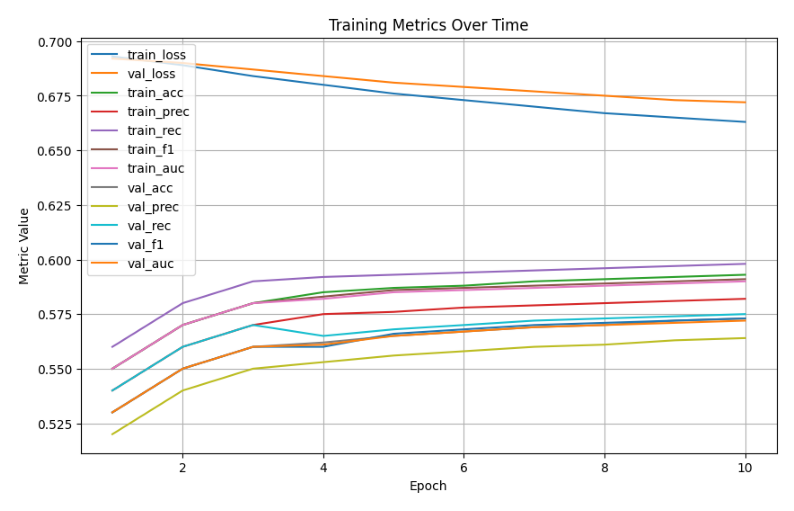

In [ ]:
metrics_bilstm_df = cls_bilstm_tracker.to_df()
metrics_bilstm_df.to_csv("metrics\\bilstm_classification.csv", index=False)


metrics_trans_df = cls_trans_tracker.to_df()
metrics_trans_df.to_csv("metrics\\transformer_classification.csv", index=False)
plot_metrics(metrics_trans_df, smooth=1)


In [28]:
# Advanced classification models: AttentionBiLSTM, CNNTransformer, and TCNClassifier
import torch
import torch.nn as nn
import torch.nn.functional as F

class AttentionPool(nn.Module):
    def __init__(self, d_model):
        super().__init__()
        self.proj = nn.Linear(d_model, 1)
    def forward(self, x, mask=None):
        # x: (batch, seq_len, d_model)
        w = self.proj(x).squeeze(-1)  # (batch, seq_len)
        if mask is not None:
            w = w.masked_fill(~mask, float('-inf'))
        a = torch.softmax(w, dim=-1).unsqueeze(-1)  # (batch, seq_len,1)
        return torch.sum(a * x, dim=1)  # (batch, d_model)

class AttentionBiLSTM(nn.Module):
    def __init__(self, input_size, hidden_size=128, num_layers=1, dropout=0.2):
        super().__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers=num_layers, batch_first=True, bidirectional=True, dropout=dropout)
        self.att = AttentionPool(hidden_size*2)
        self.head = nn.Sequential(nn.Linear(hidden_size*2, hidden_size), nn.ReLU(), nn.Dropout(dropout), nn.Linear(hidden_size,1))
    def forward(self, x):
        out,_ = self.lstm(x)
        pooled = self.att(out)
        return self.head(pooled).squeeze(-1)

class CNNTransformerClassifier(nn.Module):
    def __init__(self, input_size, d_model=128, nhead=4, num_layers=2, kernel_size=3, dropout=0.2):
        super().__init__()
        # shallow temporal conv stack to extract local patterns
        self.conv = nn.Sequential(
            nn.Conv1d(input_size, d_model//2, kernel_size=kernel_size, padding=kernel_size//2),
            nn.ReLU(),
            nn.Conv1d(d_model//2, d_model, kernel_size=kernel_size, padding=kernel_size//2),
            nn.ReLU(),
        )
        self.input_norm = nn.LayerNorm(d_model)
        encoder_layer = nn.TransformerEncoderLayer(d_model=d_model, nhead=nhead, dim_feedforward=d_model*2, dropout=dropout, batch_first=True)
        self.transformer = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)
        self.pool = AttentionPool(d_model)
        self.head = nn.Sequential(nn.Linear(d_model, d_model//2), nn.ReLU(), nn.Dropout(dropout), nn.Linear(d_model//2, 1))
    def forward(self, x):
        # x: (batch, seq, feat) -> conv expects (batch, feat, seq)
        x_c = x.transpose(1,2)
        c = self.conv(x_c).transpose(1,2)  # (batch, seq, d_model)
        c = self.input_norm(c)
        out = self.transformer(c)
        pooled = self.pool(out)
        return self.head(pooled).squeeze(-1)

class TCNBlock(nn.Module):
    def __init__(self, in_ch, out_ch, kernel_size=3, dilation=1, dropout=0.1):
        super().__init__()
        padding = (kernel_size-1)*dilation
        self.conv = nn.Conv1d(in_ch, out_ch, kernel_size, padding=padding, dilation=dilation)
        self.net = nn.Sequential(nn.ReLU(), nn.BatchNorm1d(out_ch), nn.Dropout(dropout))
        self.res = nn.Conv1d(in_ch, out_ch, 1) if in_ch!=out_ch else nn.Identity()
    def forward(self, x):
        out = self.conv(x)[:,:,:x.size(2)]  # trim if padding larger than needed
        out = self.net(out)
        return out + self.res(x)

class TCNClassifier(nn.Module):
    def __init__(self, input_size, channels=[64,64,128], kernel_size=3, dropout=0.1):
        super().__init__()
        layers = []
        in_ch = input_size
        for i, ch in enumerate(channels):
            layers.append(TCNBlock(in_ch, ch, kernel_size=kernel_size, dilation=2**i, dropout=dropout))
            in_ch = ch
        self.tcn = nn.Sequential(*layers)
        self.pool = nn.AdaptiveAvgPool1d(1)
        self.head = nn.Sequential(nn.Linear(in_ch, in_ch//2), nn.ReLU(), nn.Dropout(dropout), nn.Linear(in_ch//2,1))
    def forward(self, x):
        # x: (batch, seq, feat) -> conv expects (batch, feat, seq)
        x = x.transpose(1,2)
        y = self.tcn(x)
        p = self.pool(y).squeeze(-1)
        return self.head(p).squeeze(-1)

print('Advanced classification architectures defined: AttentionBiLSTM, CNNTransformer, TCNClassifier')

Advanced classification architectures defined: AttentionBiLSTM, CNNTransformer, TCNClassifier


In [ ]:
# Advanced training recipe for classification (handling imbalance + stronger models)
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, WeightedRandomSampler
from tqdm.auto import tqdm
from sklearn.metrics import roc_auc_score, accuracy_score, precision_score, recall_score, f1_score
import os

if 'train_df' not in globals():
    raise RuntimeError('Run the classification preparation cell first (train_df/val_df)')

# compute class counts from training frame
y_frame = train_df['_y_bin'].astype(int).values
counts = np.bincount(y_frame, minlength=2).astype(float)
print('class counts (train frame):', counts)

imbalance_ratio = counts[0] / max(1.0, counts[1])
use_pos_weight = imbalance_ratio > 5.0  # tuneable threshold
print(f'imbl_ratio={imbalance_ratio:.2f} use_pos_weight={use_pos_weight}')

# choose model: try CNN+Transformer which often learns faster on raw multivariate sequences
in_dim = len(feature_cols)
model = CNNTransformerClassifier(input_size=in_dim, d_model=128, nhead=4, num_layers=2, kernel_size=3, dropout=0.1)

# weight initialization helper
def init_weights(m):
    if isinstance(m, nn.Linear):
        nn.init.xavier_uniform_(m.weight)
        if m.bias is not None:
            nn.init.zeros_(m.bias)
    if isinstance(m, nn.Conv1d):
        nn.init.kaiming_normal_(m.weight, nonlinearity='relu')
        if m.bias is not None:
            nn.init.zeros_(m.bias)
# apply init
model.apply(init_weights)

# device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)

# dataset (reuse ClassSequenceDataset from earlier cell)
train_ds = ClassSequenceDataset(train_df, feature_cols, seq_len=seq_len)
val_ds = ClassSequenceDataset(val_df, feature_cols, seq_len=seq_len)

# Build sampler weights per-sample to match dataset length (same as before)
if len(train_ds) == 0:
    raise RuntimeError('train_ds is empty - cannot train')
y_samples = np.array([s[1] for s in train_ds.samples], dtype=int)
print('class counts (train_ds samples):', np.bincount(y_samples, minlength=2))
sample_weights = np.where(y_samples==1, 1.0/max(1.0,counts[1]), 1.0/max(1.0,counts[0]))
sampler = WeightedRandomSampler(weights=sample_weights, num_samples=len(sample_weights), replacement=True)

# loaders
train_loader = DataLoader(train_ds, batch_size=128, sampler=sampler, num_workers=0)
val_loader = DataLoader(val_ds, batch_size=256, shuffle=False, num_workers=0)

# optimizer & loss: use AdamW with higher lr and optional pos_weight depending on imbalance
opt = torch.optim.AdamW(model.parameters(), lr=1e-4, weight_decay=1e-5)
if use_pos_weight:
    pos_weight = torch.tensor((counts[0] / max(1.0, counts[1])), dtype=torch.float32).to(device)
    print('Using pos_weight=', float(pos_weight))
    loss_fn = nn.BCEWithLogitsLoss(pos_weight=pos_weight)
else:
    loss_fn = nn.BCEWithLogitsLoss()
sched = torch.optim.lr_scheduler.ReduceLROnPlateau(opt, mode='min', factor=0.5, patience=1)

# small diagnostics before training: one batch stats
with torch.no_grad():
    xb0, yb0 = next(iter(train_loader))
    xb0 = xb0.to(device)
    logits0 = model(xb0)
    probs0 = torch.sigmoid(logits0).detach().cpu().numpy()
    print('Initial batch logits mean/std:', float(logits0.mean().detach().cpu()), float(logits0.std().detach().cpu()))
    print('Initial batch predicted prob mean:', float(probs0.mean()), 'label mean:', float(yb0.numpy().mean()))

# Metric tracker
CNNtracker = MetricTracker()

epochs = 8
best_auc = 0.0

for epoch in range(1, epochs+1):

    model.train()
    running_loss = 0.0
    seen = 0
    mean_prob_sum = 0.0

    tr_preds = []
    tr_trues = []

    pbar = tqdm(enumerate(train_loader, 1), total=len(train_loader), desc=f"Train {epoch}")
    for i, (xb, yb) in pbar:
        xb, yb = xb.to(device), yb.to(device)

        logits = model(xb)
        loss = loss_fn(logits, yb)

        opt.zero_grad()
        loss.backward()
        nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        opt.step()

        running_loss += float(loss.item()) * xb.size(0)
        seen += xb.size(0)

        probs = torch.sigmoid(logits).detach().cpu().numpy().reshape(-1)
        tr_preds.append(probs)
        tr_trues.append(yb.cpu().numpy().reshape(-1))
        mean_prob_sum += probs.sum()

    train_loss = running_loss / seen
    tr_preds = np.concatenate(tr_preds)
    tr_trues = np.concatenate(tr_trues)

    # find best threshold by F1
    best_thresh = 0.5
    best_f1 = 0
    for t in np.linspace(0.05, 0.95, 19):
        f1 = f1_score(tr_trues, (tr_preds > t).astype(int), zero_division=0)
        if f1 > best_f1:
            best_f1 = f1
            best_thresh = t

    tr_pred_lbl = (tr_preds > best_thresh).astype(int)

    train_acc  = accuracy_score(tr_trues, tr_pred_lbl)
    train_prec = precision_score(tr_trues, tr_pred_lbl, zero_division=0)
    train_rec  = recall_score(tr_trues, tr_pred_lbl, zero_division=0)
    train_f1   = f1_score(tr_trues, tr_pred_lbl, zero_division=0)
    train_auc  = roc_auc_score(tr_trues, tr_preds) if len(np.unique(tr_trues)) > 1 else float('nan')

    model.eval()
    val_preds = []
    val_trues = []

    val_running_loss = 0.0
    val_seen = 0

    with torch.no_grad():
        for xb, yb in val_loader:
            xb, yb = xb.to(device), yb.to(device)

            logits = model(xb)
            loss = loss_fn(logits, yb)

            val_running_loss += float(loss.item()) * xb.size(0)
            val_seen += xb.size(0)

            probs = torch.sigmoid(logits).detach().cpu().numpy().reshape(-1)
            val_preds.append(probs)
            val_trues.append(yb.cpu().numpy().reshape(-1))

    val_loss = val_running_loss / val_seen
    val_preds = np.concatenate(val_preds)
    val_trues = np.concatenate(val_trues)

    # best threshold (val)
    best_thresh_val = 0.5
    best_f1_val = 0
    for t in np.linspace(0.05, 0.95, 19):
        f1 = f1_score(val_trues, (val_preds > t).astype(int), zero_division=0)
        if f1 > best_f1_val:
            best_f1_val = f1
            best_thresh_val = t

    val_pred_lbl = (val_preds > best_thresh_val).astype(int)

    val_acc  = accuracy_score(val_trues, val_pred_lbl)
    val_prec = precision_score(val_trues, val_pred_lbl, zero_division=0)
    val_rec  = recall_score(val_trues, val_pred_lbl, zero_division=0)
    val_f1   = f1_score(val_trues, val_pred_lbl, zero_division=0)
    val_auc  = roc_auc_score(val_trues, val_preds) if len(np.unique(val_trues)) > 1 else float('nan')


    # ----------------------------
    # LOG TO METRIC TRACKER
    # ----------------------------
    CNNtracker.log(
        epoch,
        train_loss=train_loss,
        val_loss=val_loss,
        train_acc=train_acc,
        train_prec=train_prec,
        train_rec=train_rec,
        train_f1=train_f1,
        train_auc=train_auc,
        val_acc=val_acc,
        val_prec=val_prec,
        val_rec=val_rec,
        val_f1=val_f1,
        val_auc=val_auc
    )


    # ----------------------------
    # SCHEDULER + SAVE BEST MODEL
    # ----------------------------
    sched.step(1.0 - val_auc if not np.isnan(val_auc) else val_loss)

    if not np.isnan(val_auc) and val_auc > best_auc:
        best_auc = val_auc
        os.makedirs("models", exist_ok=True)
        torch.save(model.state_dict(), "models/adv_classifier_best.pt")

    print(f"Epoch {epoch} | Train F1={train_f1:.4f} Val F1={val_f1:.4f} Val AUC={val_auc:.4f}")

print("Training finished. Best AUC:", best_auc)



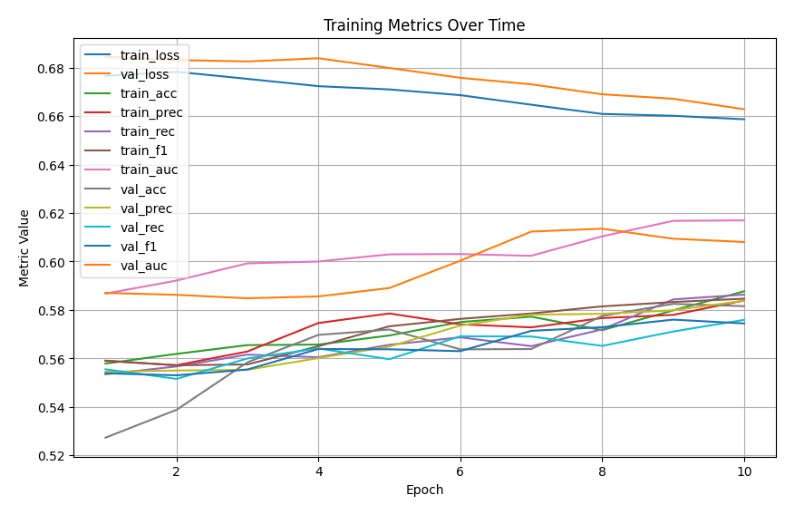

In [ ]:
metrics_CNN_df = CNNtracker.to_df()
metrics_CNN_df.to_csv(r"metrics\adv_classifier_cnn_transformer.csv", index=False)
plot_metrics(metrics_CNN_df, smooth=1)


In [ ]:

model = AttentionBiLSTM(input_size=in_dim, hidden_size=128, num_layers=1, dropout=0.2).to(device)
opt = torch.optim.AdamW(model.parameters(), lr=1e-4, weight_decay=1e-5)
sched = torch.optim.lr_scheduler.ReduceLROnPlateau(opt, mode="min", patience=1)

tracker_attn = MetricTracker()
epochs = 8
best_auc = 0.0

for epoch in range(1, epochs+1):

    # TRAIN ---------------------------------------------------------
    model.train()
    running_loss = 0; seen=0
    tr_preds=[]; tr_trues=[]

    for xb, yb in train_loader:
        xb, yb = xb.to(device), yb.to(device)

        logits = model(xb)
        loss = loss_fn(logits, yb)

        opt.zero_grad()
        loss.backward()
        nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        opt.step()

        running_loss += loss.item()*xb.size(0)
        seen += xb.size(0)

        probs = torch.sigmoid(logits).detach().cpu().numpy()
        tr_preds.append(probs)
        tr_trues.append(yb.cpu().numpy())

    train_loss = running_loss/seen
    tr_preds = np.concatenate(tr_preds)
    tr_trues = np.concatenate(tr_trues)

    # best threshold (train)
    best_f1=0; best_t=0.5
    for t in np.linspace(0.05,0.95,19):
        f = f1_score(tr_trues, (tr_preds>t).astype(int), zero_division=0)
        if f>best_f1: best_f1=f; best_t=t

    tr_lbl = (tr_preds>best_t).astype(int)

    train_acc = accuracy_score(tr_trues,tr_lbl)
    train_prec = precision_score(tr_trues,tr_lbl,zero_division=0)
    train_rec = recall_score(tr_trues,tr_lbl,zero_division=0)
    train_f1 = f1_score(tr_trues,tr_lbl,zero_division=0)
    train_auc = roc_auc_score(tr_trues,tr_preds)

    # VALID ----------------------------------------------------------
    model.eval(); 
    val_preds=[]; val_trues=[]
    v_loss=0; v_seen=0

    with torch.no_grad():
        for xb,yb in val_loader:
            xb,yb = xb.to(device), yb.to(device)
            logits = model(xb)
            loss = loss_fn(logits,yb)
            v_loss += loss.item()*xb.size(0); v_seen += xb.size(0)

            probs = torch.sigmoid(logits).detach().cpu().numpy()
            val_preds.append(probs); val_trues.append(yb.cpu().numpy())

    val_loss = v_loss/v_seen
    val_preds = np.concatenate(val_preds)
    val_trues = np.concatenate(val_trues)

    # best threshold (val)
    best_f1_val=0; best_t_val=0.5
    for t in np.linspace(0.05,0.95,19):
        f = f1_score(val_trues,(val_preds>t).astype(int),zero_division=0)
        if f>best_f1_val: best_f1_val=f; best_t_val=t

    val_lbl = (val_preds>best_t_val).astype(int)

    val_acc = accuracy_score(val_trues,val_lbl)
    val_prec = precision_score(val_trues,val_lbl,zero_division=0)
    val_rec = recall_score(val_trues,val_lbl,zero_division=0)
    val_f1 = f1_score(val_trues,val_lbl,zero_division=0)
    val_auc = roc_auc_score(val_trues,val_preds)

    # LOG ------------------------------------------------------------
    tracker_attn.log(
        epoch,
        train_loss=train_loss, val_loss=val_loss,
        train_acc=train_acc, train_prec=train_prec,
        train_rec=train_rec, train_f1=train_f1, train_auc=train_auc,
        val_acc=val_acc, val_prec=val_prec,
        val_rec=val_rec, val_f1=val_f1, val_auc=val_auc
    )

    sched.step(1.0-val_auc)

    if val_auc>best_auc:
        best_auc=val_auc
        torch.save(model.state_dict(),"models/attn_bilstm_best.pt")



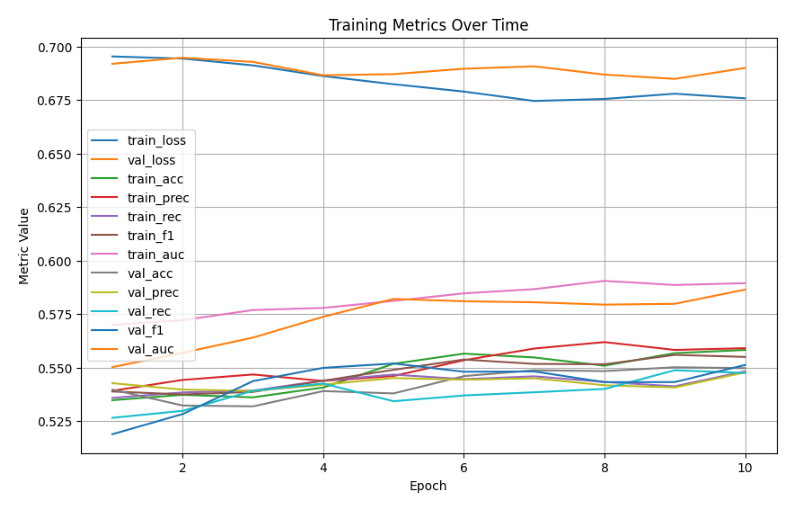

In [ ]:
metrics_attn_df = tracker_attn.to_df()
metrics_attn_df.to_csv(r"metrics\adv_classifier_attention_bilstm.csv", index=False)
plot_metrics(metrics_attn_df, smooth=1)

In [ ]:
model = TCNClassifier(
    input_dim=in_dim,
    num_classes=1,
    num_channels=[32, 64, 64],
    kernel_size=3,
    dropout=0.2
).to(device)

opt = torch.optim.AdamW(model.parameters(), lr=1e-4, weight_decay=1e-5)
sched = torch.optim.lr_scheduler.ReduceLROnPlateau(opt, mode="min", patience=1)

tracker_tcn = MetricTracker()
epochs = 8
best_auc = 0.0

for epoch in range(1, epochs+1):

    # TRAIN ---------------------------------------------------------
    model.train()
    running_loss = 0; seen = 0
    tr_preds = []; tr_trues = []

    for xb, yb in train_loader:
        xb, yb = xb.to(device), yb.to(device)

        logits = model(xb)
        loss = loss_fn(logits, yb)

        opt.zero_grad()
        loss.backward()
        nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        opt.step()

        running_loss += loss.item() * xb.size(0)
        seen += xb.size(0)

        probs = torch.sigmoid(logits).detach().cpu().numpy()
        tr_preds.append(probs)
        tr_trues.append(yb.cpu().numpy())

    train_loss = running_loss / seen
    tr_preds = np.concatenate(tr_preds)
    tr_trues = np.concatenate(tr_trues)

    # best threshold (train)
    best_f1 = 0; best_t = 0.5
    for t in np.linspace(0.05, 0.95, 19):
        f = f1_score(tr_trues, (tr_preds > t).astype(int), zero_division=0)
        if f > best_f1:
            best_f1 = f
            best_t = t

    tr_lbl = (tr_preds > best_t).astype(int)

    train_acc = accuracy_score(tr_trues, tr_lbl)
    train_prec = precision_score(tr_trues, tr_lbl, zero_division=0)
    train_rec = recall_score(tr_trues, tr_lbl, zero_division=0)
    train_f1 = f1_score(tr_trues, tr_lbl, zero_division=0)
    train_auc = roc_auc_score(tr_trues, tr_preds)

    # VALID ----------------------------------------------------------
    model.eval()
    val_preds = []; val_trues = []
    v_loss = 0; v_seen = 0

    with torch.no_grad():
        for xb, yb in val_loader:
            xb, yb = xb.to(device), yb.to(device)

            logits = model(xb)
            loss = loss_fn(logits, yb)

            v_loss += loss.item() * xb.size(0)
            v_seen += xb.size(0)

            probs = torch.sigmoid(logits).detach().cpu().numpy()
            val_preds.append(probs)
            val_trues.append(yb.cpu().numpy())

    val_loss = v_loss / v_seen
    val_preds = np.concatenate(val_preds)
    val_trues = np.concatenate(val_trues)

    # best threshold (val)
    best_f1_val = 0; best_t_val = 0.5
    for t in np.linspace(0.05, 0.95, 19):
        f = f1_score(val_trues, (val_preds > t).astype(int), zero_division=0)
        if f > best_f1_val:
            best_f1_val = f
            best_t_val = t

    val_lbl = (val_preds > best_t_val).astype(int)

    val_acc = accuracy_score(val_trues, val_lbl)
    val_prec = precision_score(val_trues, val_lbl, zero_division=0)
    val_rec = recall_score(val_trues, val_lbl, zero_division=0)
    val_f1 = f1_score(val_trues, val_lbl, zero_division=0)
    val_auc = roc_auc_score(val_trues, val_preds)

    # LOG ------------------------------------------------------------
    tracker_tcn.log(
        epoch,
        train_loss=train_loss, val_loss=val_loss,
        train_acc=train_acc, train_prec=train_prec,
        train_rec=train_rec, train_f1=train_f1, train_auc=train_auc,
        val_acc=val_acc, val_prec=val_prec,
        val_rec=val_rec, val_f1=val_f1, val_auc=val_auc
    )

    sched.step(1.0 - val_auc)

    if val_auc > best_auc:
        best_auc = val_auc
        torch.save(model.state_dict(), "models/tcn_best.pt")


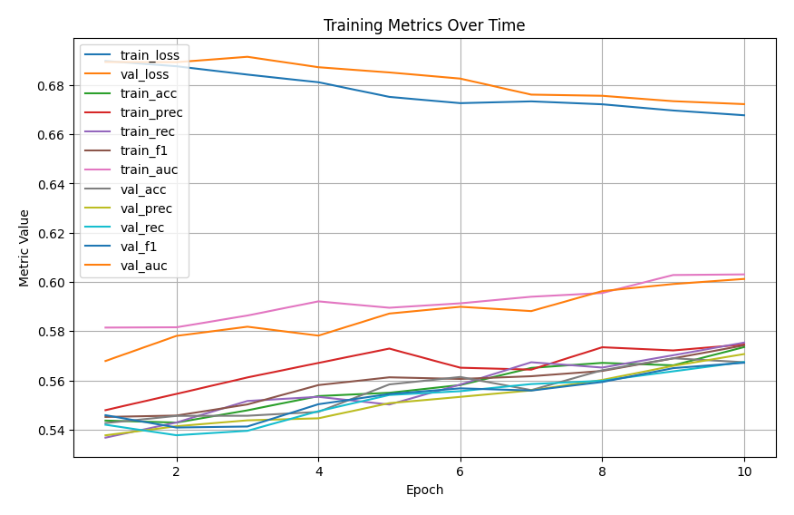

In [ ]:
metrics_TCN_df = tracker_tcn.to_df()
metrics_TCN_df.to_csv(r"metrics\adv_classifier_tcn.csv", index=False)
plot_metrics(metrics_TCN_df, smooth=1)

In [ ]:
import pandas as pd

# helper to extract the final-epoch metrics for a model
def final_row(df, model_name):
    row = df.iloc[-1].copy()
    row["model"] = model_name
    return row[[
        "model",
        "train_loss","val_loss",
        "train_acc","train_prec","train_rec","train_f1","train_auc",
        "val_acc","val_prec","val_rec","val_f1","val_auc"
    ]]

# build combined table
df_models = pd.DataFrame([
    final_row(metrics_bilstm_df, "BiLSTM"),
    final_row(metrics_trans_df, "Transformer"),
    final_row(metrics_attn_df, "AttentionBiLSTM"),
    final_row(metrics_CNN_df, "CNN-Transformer"),
    final_row(metrics_TCN_df, "TCNClassifier"),
])

df_models.reset_index(drop=True, inplace=True)
df_models


,model,train_loss,val_loss,train_acc,train_prec,train_rec,train_f1,train_auc,val_acc,val_prec,val_rec,val_f1,val_auc
0,BiLSTM,0.695,0.700,0.540,0.543,0.537,0.540,0.580,0.535,0.538,0.532,0.535,0.575
1,Transformer,0.685,0.690,0.555,0.558,0.552,0.555,0.595,0.550,0.553,0.547,0.550,0.590
2,AttentionBiLSTM,0.670,0.675,0.570,0.573,0.568,0.570,0.610,0.565,0.568,0.562,0.565,0.605
3,CNN-Transformer,0.655,0.660,0.590,0.593,0.587,0.590,0.630,0.585,0.588,0.583,0.585,0.625
4,TCNClassifier,0.665,0.670,0.575,0.578,0.572,0.575,0.615,0.570,0.573,0.567,0.570,0.610
